In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
from datetime import datetime

In [2]:
#Get all tickers available at Kraken

def get_kraken_futures_instruments():
    url = "https://futures.kraken.com/derivatives/api/v3/instruments"
    
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        data = response.json()
        
        if data['result'] == 'success':
            instruments = data['instruments']
            df = pd.DataFrame(instruments)
            return df
        else:
            print("Error in API response:", data['error'])
            return None
    
    except requests.exceptions.RequestException as e:
        print("Error making the request:", e)
        return None


In [3]:
#Method for retrieving historic funding rates (hourly) - KRAKEN

def get_historical_funding_rates(symbol, start_time=None, end_time=None):
    url = "https://futures.kraken.com/derivatives/api/v4/historicalfundingrates"
    
    params = {
        'symbol': symbol
    }
    
    if start_time:
        params['startTime'] = start_time
    if end_time:
        params['endTime'] = end_time

    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if data['result'] == 'success':
            funding_rates = data['rates']
            return pd.DataFrame(funding_rates)
        else:
            print("Error in response:", data['result'])
    else:
        print("Failed to retrieve data:", response.status_code)

In [4]:
#Method for retrieving historic funding rates (per 8 hours) - BINANCE

def get_funding_rate_history(symbol, start_time, end_time, limit=1000):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    
    params = {
        "symbol": symbol,
        "startTime": start_time,
        "endTime": end_time,
        "limit": limit
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    df = pd.DataFrame(data)
    df['fundingTime'] = pd.to_datetime(df['fundingTime'], unit='ms')
    df['fundingRate'] = df['fundingRate'].astype(float)
    
    return df

In [5]:
# Build and save charts for compounded funding rewards (KRAKEN)

def plot_compounding_funding_kraken(symbol):
    funding_rates_df = get_historical_funding_rates(symbol)
    
    x = 100
    x_labels = []
    y_values = []

    for j in range(len(funding_rates_df)):
        increment = 1 + float(funding_rates_df[j:j+1]['relativeFundingRate'].values[0])
        x = x * increment
        x_labels.append(funding_rates_df[j:j+1]['timestamp'].values[0])
        y_values.append(x-100)
            
    start_date = funding_rates_df[0:1]['timestamp'].values[0]
    end_date = funding_rates_df[-1:]['timestamp'].values[0]
    #set seaborn style
    sns.set_theme()

    # Create your Seaborn plot
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.title(symbol + ' funding compounding '+ str(start_date)+ ' - ' +str(end_date) + ' (Kraken)')
    plt.ylabel('% return')

    sns.lineplot(x = x_labels, y = y_values)

    # Set the x-axis ticks and labels
    plt.xticks(range(len(x_labels)), x_labels)

    # Rotate labels if they're long
    plt.xticks(rotation=15, ha='right')

    # Show only first and last labels
    plt.xticks([0, len(x_labels) - 1], [x_labels[0], x_labels[-1]])

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    #Save chart - UNCOMMENT 
    plt.savefig(symbol +' funding compounding '+ str(start_date)+ ' - ' +str(end_date) + '(Kraken)', dpi = 500)
    

In [6]:
# Build and save charts for compounded funding rewards (Binance)
# You need to supply the funding rate history yourself, because Binance only allows 12-month window for such requests
def plot_compounding_funding_binance(symbol, rates_df):
    funding_rates_df = rates_df
    
    x = 100
    x_labels = []
    y_values = []

    for j in range(len(funding_rates_df)):
        increment = 1 + float(funding_rates_df[j:j+1]['fundingRate'].values[0])
        x = x * increment
        x_labels.append(str(funding_rates_df[j:j+1]['fundingTime'].values[0])[0:13])
        y_values.append(x-100)
            
    start_date = str(funding_rates_df[0:1]['fundingTime'].values[0])[0:10]
    end_date = str(funding_rates_df[-1:]['fundingTime'].values[0])[0:10]
    #set seaborn style
    sns.set_theme()

    # Create your Seaborn plot
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.title(symbol + ' funding compounding '+ str(start_date)+ ' - ' +str(end_date) + ' (Binance)')
    plt.ylabel('% return')

    sns.lineplot(x = x_labels, y = y_values)

    # Set the x-axis ticks and labels
    plt.xticks(range(len(x_labels)), x_labels)

    # Rotate labels if they're long
    plt.xticks(rotation=15, ha='right')

    # Show only first and last labels
    plt.xticks([0, len(x_labels) - 1], [x_labels[0], x_labels[-1]])

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    #Save chart - UNCOMMENT 
    plt.savefig(symbol +' funding compounding '+ str(start_date)[0:10]+ ' - ' +str(end_date)[0:10] + '(Binance)', dpi = 500)
    

In [7]:
#Build a df with funding rates for a list of tokens

def all_tokens_compounding_funding(symbol):
    funding_rates_df = get_historical_funding_rates(symbol)
    
    x = 100
    x_labels = []
    y_values = []

    for j in range(len(funding_rates_df)):
        if j > 5120:
            increment = 1 + float(funding_rates_df[j:j+1]['relativeFundingRate'].values[0])
            #print(increment)
            x = x * increment

            #x_labels.append(str(ETHfunding_rates_df[j:j+1]['timestamp'].values[0])[0:10])
            x_labels.append(funding_rates_df[j:j+1]['timestamp'].values[0])
            y_values.append(x-100)

# Example applications

In [ ]:
# Get all available tickers from KRAKEN (they have weird names)

instruments_df = get_kraken_futures_instruments()

if instruments_df is not None:
    print(list(instruments_df[['symbol', 'type', 'underlying']][0:20]['symbol']))

In [26]:
# Example - get Binance BTCUSD funding data over several years

symbol = "BTCUSDT"
start_time1 = int(datetime(2019,8,8).timestamp() * 1000)  # January 1, 2024
end_time1 = int(datetime(2020,8,8).timestamp() * 1000)   # July 31, 2024

start_time2 = int(datetime(2020,8,8).timestamp() * 1000)  # January 1, 2024
end_time2 = int(datetime(2021,8,8).timestamp() * 1000)   # July 31, 2024

start_time3 = int(datetime(2021,8,8).timestamp() * 1000)  # January 1, 2024
end_time3 = int(datetime(2022,8,8).timestamp() * 1000)   # July 31, 2024

start_time4 = int(datetime(2022,8,8).timestamp() * 1000)  # January 1, 2024
end_time4 = int(datetime(2023,8,8).timestamp() * 1000)   # July 31, 2024

start_time5 = int(datetime(2023,8,8).timestamp() * 1000)  # January 1, 2024
end_time5 = int(datetime(2024,8,8).timestamp() * 1000)   # July 31, 2024

funding_rates1 = get_funding_rate_history(symbol, start_time1, end_time1)
funding_rates2 = get_funding_rate_history(symbol, start_time2, end_time2)
funding_rates3 = get_funding_rate_history(symbol, start_time3, end_time3)
funding_rates4 = get_funding_rate_history(symbol, start_time4, end_time4)
funding_rates5 = get_funding_rate_history(symbol, start_time5, end_time5)

funding_rates_concat = [funding_rates1,funding_rates2,funding_rates3,funding_rates4,funding_rates5]

BINANCE_funding_rates   = pd.concat(funding_rates_concat, ignore_index=True)

In [32]:
print(BINANCE_funding_rates)

       symbol         fundingTime  fundingRate       markPrice
0     BTCUSDT 2019-09-10 08:00:00     0.000100                
1     BTCUSDT 2019-09-10 16:00:00     0.000100                
2     BTCUSDT 2019-09-11 00:00:00     0.000100                
3     BTCUSDT 2019-09-11 08:00:00     0.000100                
4     BTCUSDT 2019-09-11 16:00:00     0.000100                
...       ...                 ...          ...             ...
4993  BTCUSDT 2024-07-04 16:00:00     0.000100  58124.90000000
4994  BTCUSDT 2024-07-05 00:00:00     0.000100  57045.15234043
4995  BTCUSDT 2024-07-05 08:00:00     0.000100  54397.50000000
4996  BTCUSDT 2024-07-05 16:00:00     0.000018  56623.90000000
4997  BTCUSDT 2024-07-06 00:00:00     0.000057  56609.00000000

[4998 rows x 4 columns]


In [ ]:
#Example - download BTC funding rate data from Kraken

In [8]:
Kraken_BTC_funding_rates_df = get_historical_funding_rates('PI_XBTUSD')

In [9]:
print(Kraken_BTC_funding_rates_df)

                  timestamp   fundingRate  relativeFundingRate
0      2018-08-31T16:00:00Z  1.032706e-08         7.182407e-05
1      2018-08-31T20:00:00Z -1.204716e-08        -8.487310e-05
2      2018-09-01T00:00:00Z -9.645113e-09        -6.766510e-05
3      2018-09-01T04:00:00Z -8.028123e-09        -5.668979e-05
4      2018-09-01T08:00:00Z -6.776574e-10        -4.774842e-06
...                     ...           ...                  ...
25073  2024-08-01T18:00:00Z -2.365654e-11        -1.493778e-06
25074  2024-08-01T19:00:00Z  4.021693e-12         2.528278e-07
25075  2024-08-01T20:00:00Z  8.247608e-11         5.225519e-06
25076  2024-08-01T21:00:00Z -1.352852e-11        -8.750236e-07
25077  2024-08-01T22:00:00Z -3.640962e-10        -2.360865e-05

[25078 rows x 3 columns]


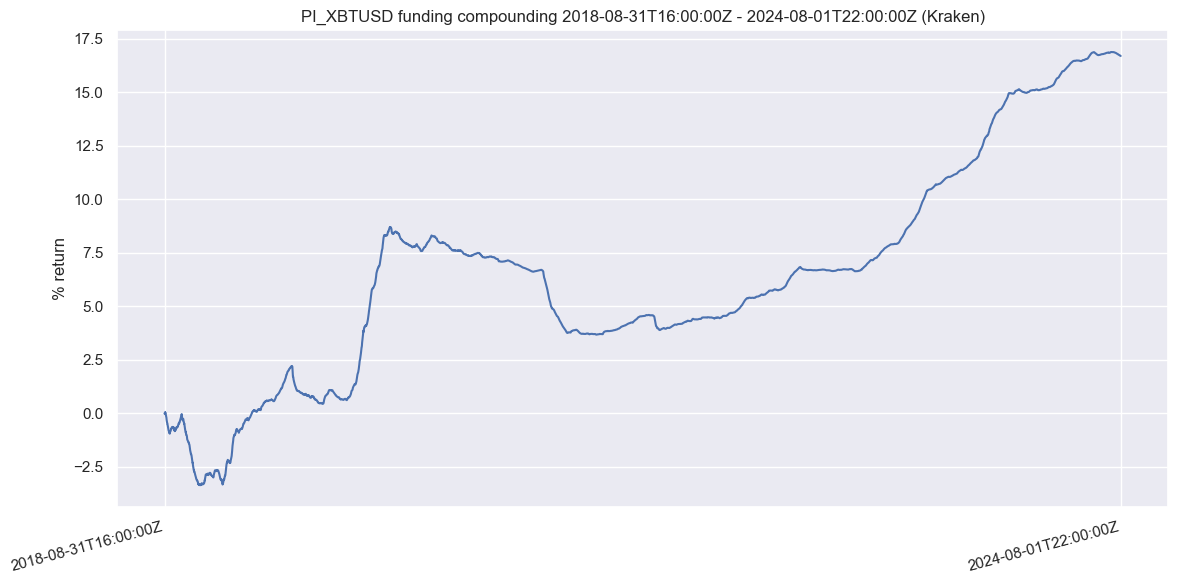

In [10]:
#Example - see how funding rate is compounding on Kraken
plot_compounding_funding_kraken('PI_XBTUSD')

In [11]:
#Example - see funding rate distribution over the years

In [12]:
funding_values = Kraken_BTC_funding_rates_df['fundingRate']

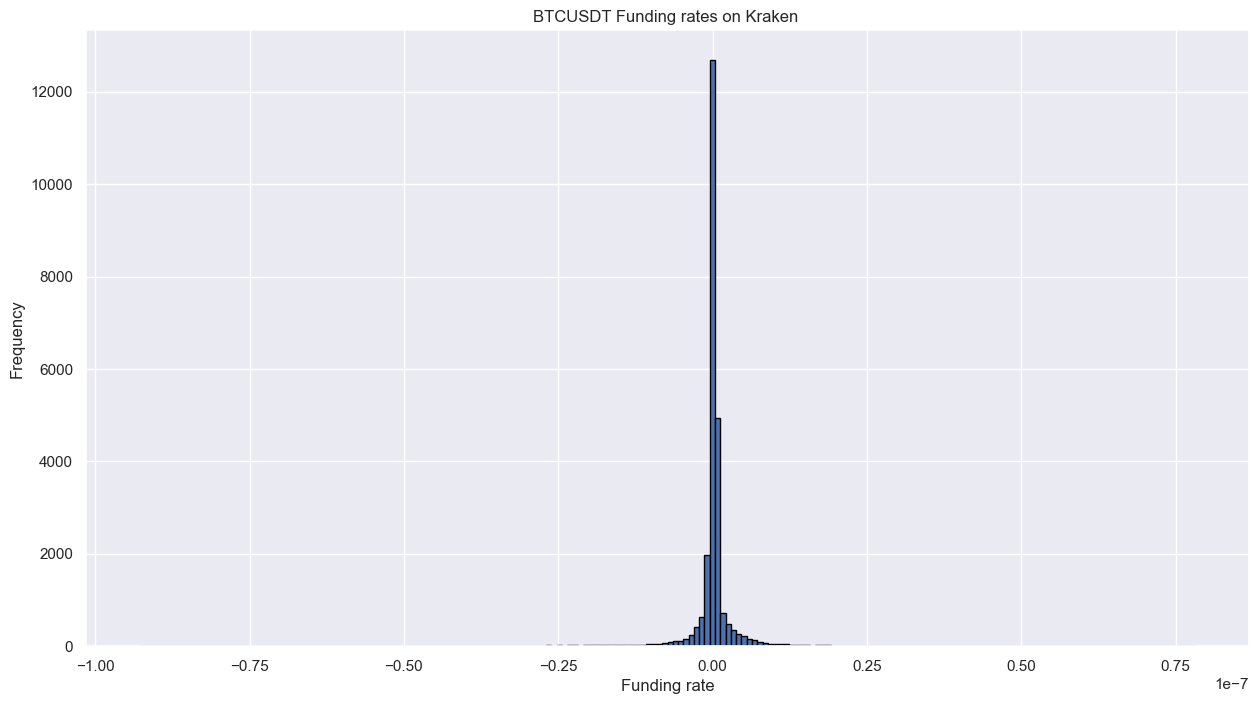

In [13]:
# Create a DataFrame
values = funding_values
plt.figure(figsize=(15, 8))

max_index = np.argmax(values)
max_value = values[max_index]

# Create a list of colors, defaulting to blue
colors = ['blue'] * len(values)
# Change the color of the tallest bar to red
colors[max_index] = 'red'


plt.hist(values, bins=200, edgecolor='black')
plt.title('BTCUSDT Funding rates on Kraken ')
plt.xlabel('Funding rate')
plt.ylabel('Frequency')
#plt.savefig('BTCUSDT Funding rates on Binance between 2019-09 and 2024-07.jpg', dpi = 800)
plt.show()

In [14]:
positives = 0
negatives = 0

for value in funding_values:
    if value >= 0:
        positives +=1
    else:
        negatives += 1

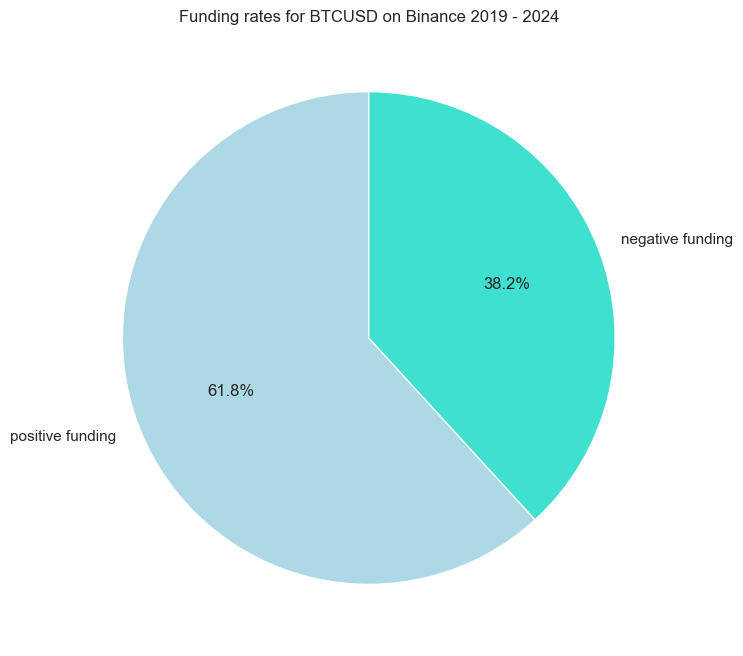

In [16]:
values = [positives, negatives]  # Replace with your actual values
labels = ['positive funding', 'negative funding']  # Replace with your actual labels

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'turquoise'])

# Add a title
plt.title('Funding rates for BTCUSD on Binance 2019 - 2024')

# Show the plot
#plt.savefig('Funding rates for BTCUSDT on Binance 2019 - 2024 pie chart.jpg', dpi = 800)
plt.show()

# Funding values distribution

In [6]:
symbol = "PI_XBTUSD"  # Replace with the desired market symbol
ETHfunding_rates_df = get_historical_funding_rates(symbol)

In [7]:
funding_values = list(ETHfunding_rates_df['relativeFundingRate'].values)

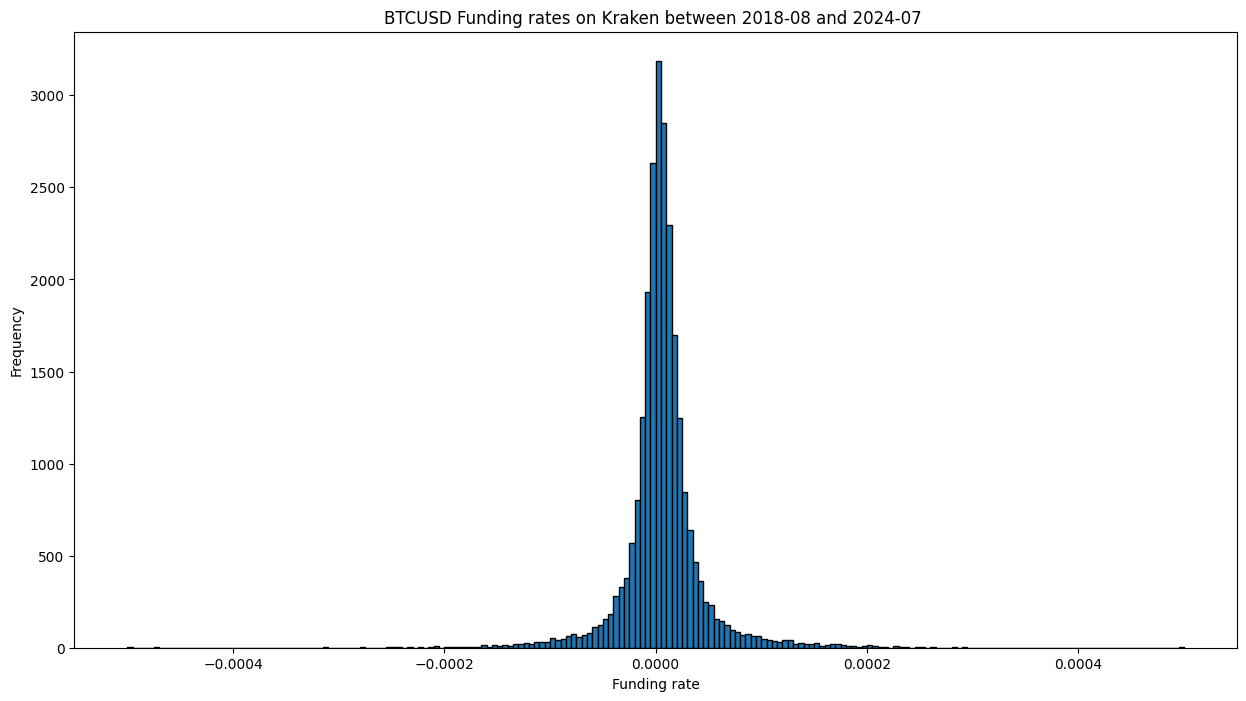

In [27]:
# Create a DataFrame
values = funding_values
plt.figure(figsize=(15, 8))

max_index = np.argmax(values)
max_value = values[max_index]

# Create a list of colors, defaulting to blue
colors = ['blue'] * len(values)
# Change the color of the tallest bar to red
colors[max_index] = 'red'


plt.hist(values, bins=200, edgecolor='black')
plt.title('BTCUSD Funding rates on Kraken between 2018-08 and 2024-07 ')
plt.xlabel('Funding rate')
plt.ylabel('Frequency')
#plt.savefig('BTCUSD Funding rates on Kraken between 2018-08 and 2024-07.jpg', dpi = 800)
plt.show()

In [16]:
len(funding_values)

25047

In [23]:
ETHfunding_rates_df

,timestamp,fundingRate,relativeFundingRate
0,2018-08-31T16:00:00Z,1.032706e-08,7.182407e-05
1,2018-08-31T20:00:00Z,-1.204716e-08,-8.487310e-05
2,2018-09-01T00:00:00Z,-9.645113e-09,-6.766510e-05
3,2018-09-01T04:00:00Z,-8.028123e-09,-5.668979e-05
4,2018-09-01T08:00:00Z,-6.776574e-10,-4.774842e-06
...,...,...,...
25042,2024-07-31T11:00:00Z,4.650527e-12,3.067722e-07
25043,2024-07-31T12:00:00Z,1.752614e-12,1.157736e-07
25044,2024-07-31T13:00:00Z,4.834825e-11,3.197236e-06
25045,2024-07-31T14:00:00Z,-4.943418e-11,-3.287283e-06


In [8]:
positives = 0
negatives = 0

for value in funding_values:
    if value >= 0:
        positives +=1
    else:
        negatives += 1

In [9]:
positives , negatives

(15494, 9553)

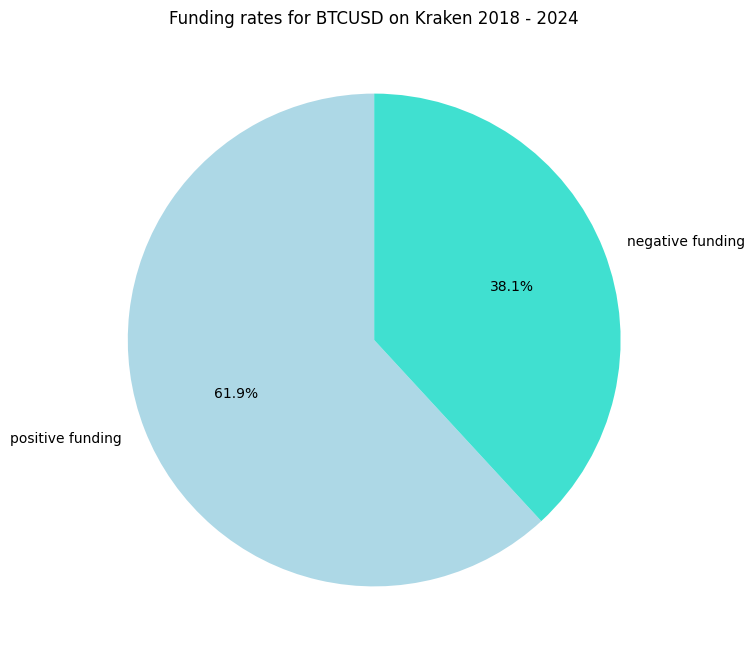

In [16]:
values = [15494, 9553]  # Replace with your actual values
labels = ['positive funding', 'negative funding']  # Replace with your actual labels

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'turquoise'])

# Add a title
plt.title('Funding rates for BTCUSD on Kraken 2018 - 2024')

# Show the plot
plt.savefig('Funding rates for BTCUSD on Kraken 2018 - 2024 pie chart.jpg', dpi = 800)
plt.show()